The Kats library from FB research (https://github.com/facebookresearch/Kats) seems to provide some promising features, such as FFT-based automatic seasonality detection, outlier detection, and changepoint detection. I wanted to study whether these would yeald any additional performance compared to the my existing models. Kats installation was not so succesfull on Windows so I tried it in Google Colab.

In [1]:
!pip install kats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 612 kB 16.4 MB/s 
     |████████████████████████████████| 950 kB 68.1 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
     |████████████████████████████████| 62.6 MB 1.2 MB/s 
     |████████████████████████████████| 245 kB 61.4 MB/s 
     |████████████████████████████████| 347 kB 60.3 MB/s 
     |████████████████████████████████| 155 kB 61.0 MB/s 
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
    Running setup.py install for fbprophet ... done
  DEPRECATION: fbpr

In [2]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Python Scripts/CC_call_load_masked.csv')
df.rename(columns={'Datetime': 'ds', 'Call_Load_s': 'y'}, inplace=True)

Mounted at /content/drive


In [3]:
df['ds'] = pd.to_datetime(df['ds'])
df.sort_values(by='ds', inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df_2 = df.loc[df['y'] > 0]

# Construct TimeSeriesData object
df_2 = df_2.rename(columns={"ds": "time", "y": "value"})

Kats turned out to be sensitive to duplicated time values so I had to eliminate those rows.

In [5]:
df_2.time.is_unique

False

In [6]:
times = df_2["time"]
df_2[times.isin(times[times.duplicated()])].sort_values("time")

,time,value
112487,2018-11-01 02:00:00,909.408864
112488,2018-11-01 02:00:00,879.649149
121223,2019-10-31 02:00:00,770.250000
121224,2019-10-31 02:00:00,756.107143


In [7]:
df_2 = df_2.loc[~df_2.time.duplicated(), :]

In [8]:
from kats.consts import TimeSeriesData
ts = TimeSeriesData(df_2)

The Prophet method (https://facebook.github.io/prophet) comes out of the box from the Kats framework. The interface is super light, the result and visualisation are high quality.
Prophet (https://peerj.com/preprints/3190/) is a generalized additive model which is capable to model multiple seasonalities with various terms (orders) in a partial Fourier sum.

In [13]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='additive')

# create a prophet model instance
m = ProphetModel(ts, params)

# fit model simply by calling m.fit()
m.fit()

# make predictions
fcst = m.predict(steps=300, freq="H")

Here is the plot of predictions for the next 300 hours. The curve follows hourly and daily seasonalities well.

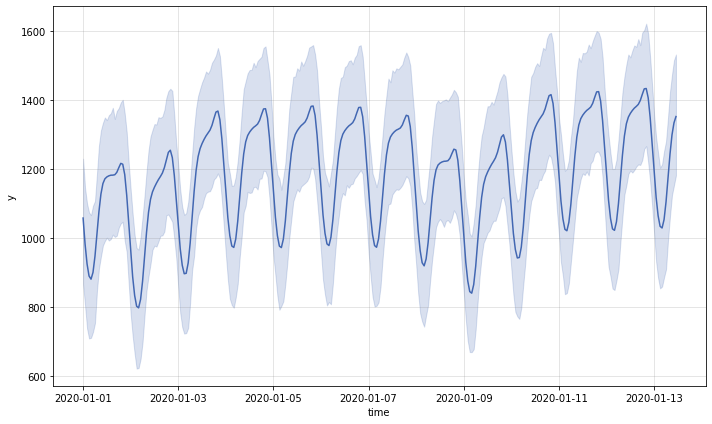

In [14]:
m.plot()

In [15]:
fcst_2 = m.predict(steps=df.loc[df['y'] == 0]['y'].size, freq="H")

Here is the plot for the whole requested interval. Among all models Prophet provides the most usable multi-step forecasting for such a long interval.

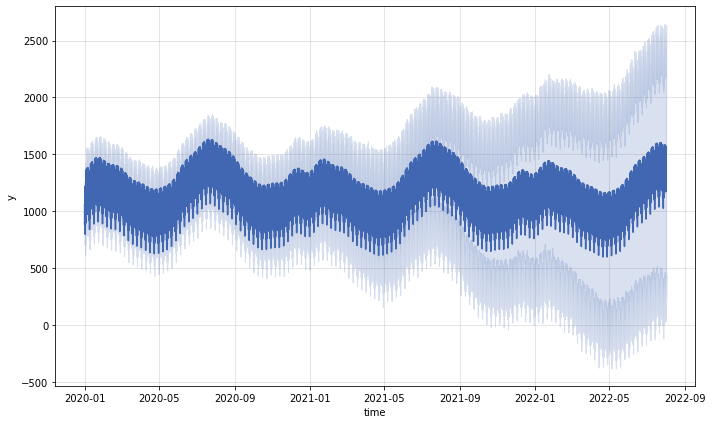

In [16]:
m.plot()

In [56]:
plt.rcParams["figure.figsize"] = (20,5)

In [17]:
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import numpy as np

n    = len(df_2["value"].values)
yf   = rfft(df_2["value"].values)
xf   = rfftfreq(n)

We know that we have 122708 hours of data.
Which means:
~10226 half-days,
~5113 days,
~730 weeks,
~183 months,
~60 quarters,
~30 half-years,
~15 years


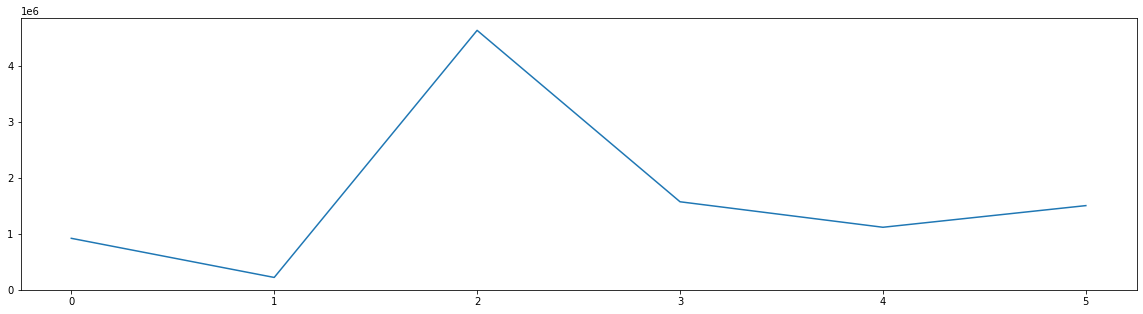

In [75]:
plt.plot(np.abs(yf[12:18]))

Freq: 14 (yearly)

In [90]:
yf[:14] = 0

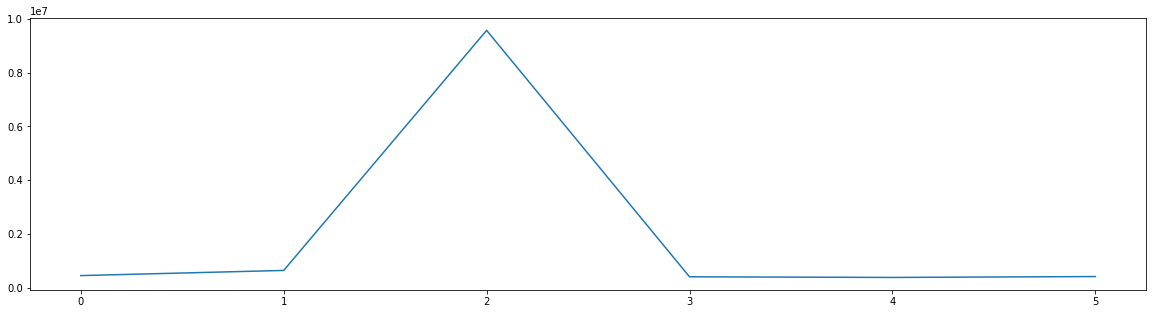

In [76]:
plt.plot(np.abs(yf[26:32]))

Freq: 28 (half yearly)

In [91]:
yf[15:28] = 0

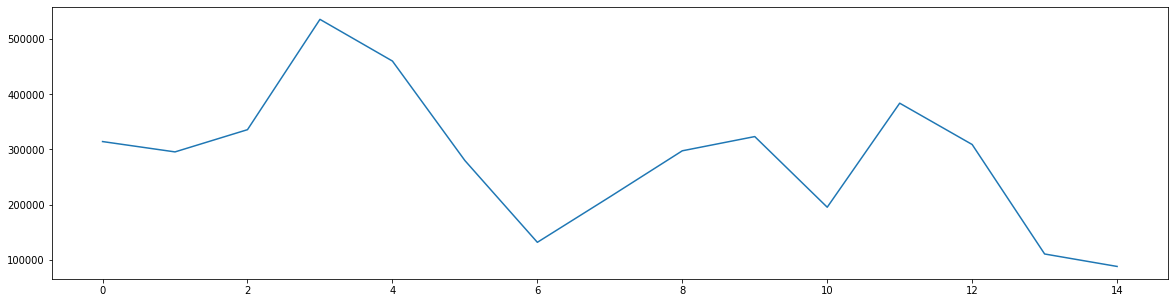

In [77]:
plt.plot(np.abs(yf[175:190]))

Freq: 178 (monthly)

In [92]:
yf[29:178] = 0

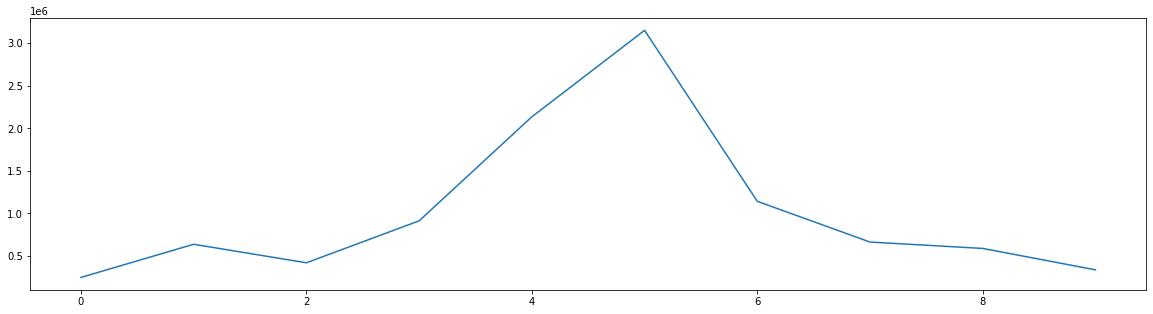

In [84]:
plt.plot(np.abs(yf[726:736]))

Freq: 731 (weekly)

In [93]:
yf[179:731] = 0

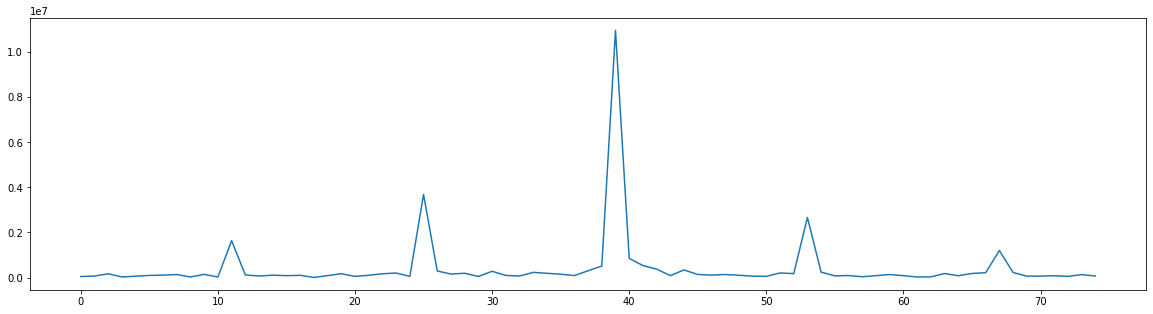

In [80]:
plt.plot(np.abs(yf[5075:5150]))

Freq: 5114 (daily)

In [94]:
yf[732:5114] = 0

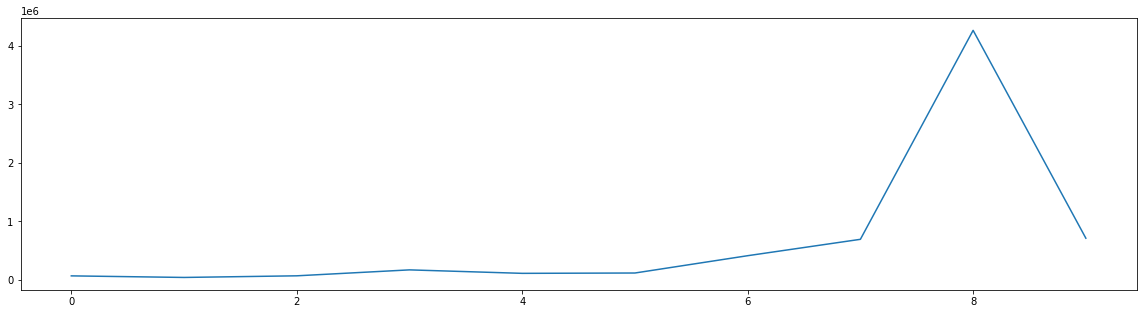

In [83]:
plt.plot(np.abs(yf[10220:10230]))

Freq: 10228 (half daily)

In [96]:
yf[5115:10228] = 0
yf[10229:] = 0

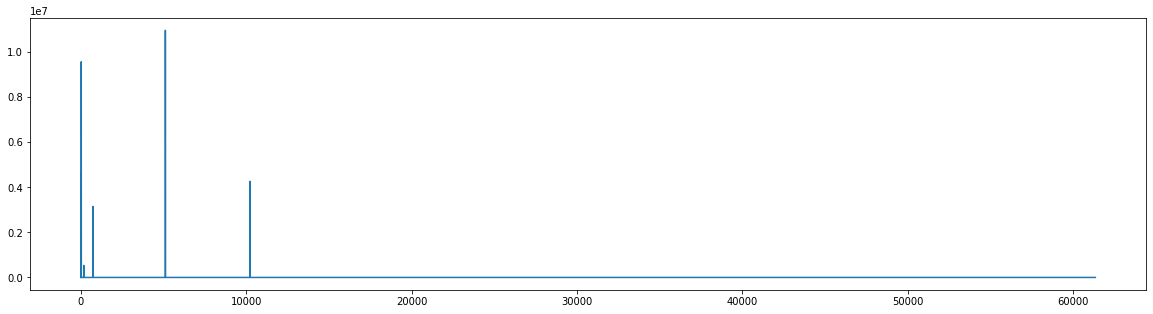

In [97]:
plt.plot(np.abs(yf[:]))

([<matplotlib.lines.Line2D at 0x7f9a5af32e50>],
 [<matplotlib.lines.Line2D at 0x7f9a5af54be0>])

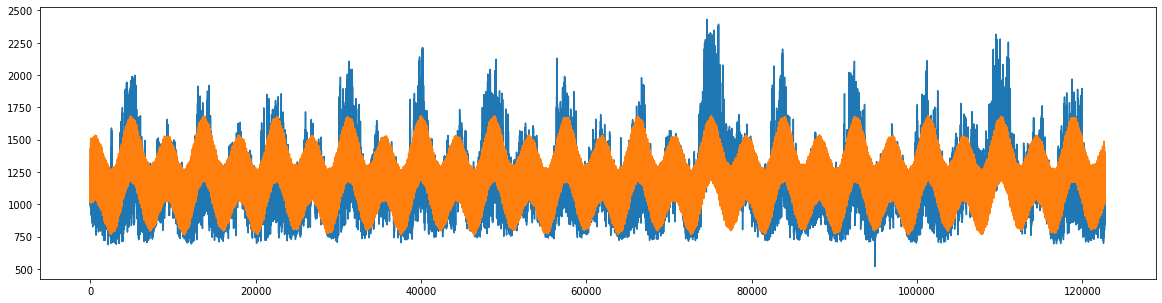

In [106]:
from scipy.fft import irfft
df_2_clean = irfft(yf)
df_2_clean += np.abs(df_2['value'][0] - df_2_clean[0])
plt.plot(df_2['value']), plt.plot(df_2_clean)

In [110]:
df_2['clean_value'] = pd.Series(df_2_clean, index=df_2.index)
df_2

,time,value,clean_value
0,2005-12-31 01:00:00,1085.464286,1085.464286
1,2005-12-31 02:00:00,1045.178571,1033.743218
2,2005-12-31 03:00:00,1012.750000,1008.987060
3,2005-12-31 04:00:00,996.392857,1014.792038
4,2005-12-31 05:00:00,1002.035714,1048.948038
...,...,...,...
122705,2019-12-31 19:00:00,1173.857143,1391.621697
122706,2019-12-31 20:00:00,1161.785714,1357.932406
122707,2019-12-31 21:00:00,1147.535714,1302.833856
122708,2019-12-31 22:00:00,1118.500000,1232.020825


In [126]:
df_2 = df_2.rename(columns={"value": "original_value", "clean_value": "value"})

In [136]:
df_3 = df_2.copy()

In [137]:
del df_3['original_value']

In [138]:
ts_2 = TimeSeriesData(df_3)

In [139]:
params_2 = ProphetParams(seasonality_mode='additive')

# create a prophet model instance
m_2 = ProphetModel(ts_2, params_2)

# fit model simply by calling m.fit()
m_2.fit()

# make predictions
fcst_2 = m_2.predict(steps=300, freq="H")

All these look much nicer

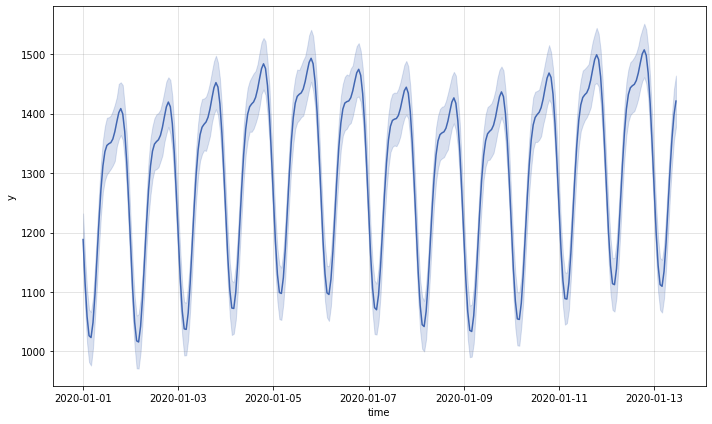

In [143]:
m_2.plot()

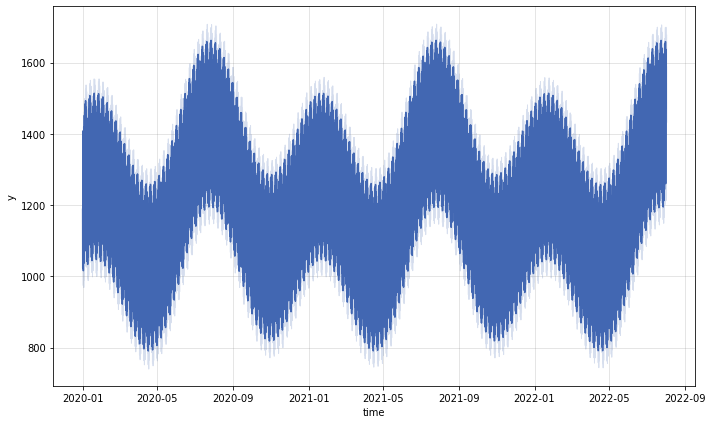

In [144]:
fcst_3 = m_2.predict(steps=df.loc[df['y'] == 0]['y'].size, freq="H")
m_2.plot()

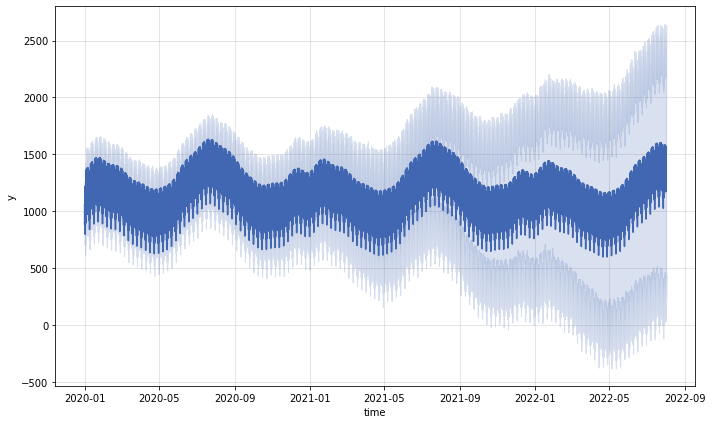

In [145]:
m.plot()